In [3]:
import mlp.layers as layers
import mlp.initialisers as init
import numpy as np
from scipy import signal as sg

class ConvolutionalLayer(layers.LayerWithParameters):
    """Layer implementing a 2D convolution-based transformation of its inputs.

    The layer is parameterised by a set of 2D convolutional kernels, a four
    dimensional array of shape
        (num_output_channels, num_input_channels, kernel_dim_1, kernel_dim_2)
    and a bias vector, a one dimensional array of shape
        (num_output_channels,)
    i.e. one shared bias per output channel.

    Assuming no-padding is applied to the inputs so that outputs are only
    calculated for positions where the kernel filters fully overlap with the
    inputs, and that unit strides are used the outputs will have spatial extent
        output_dim_1 = input_dim_1 - kernel_dim_1 + 1
        output_dim_2 = input_dim_2 - kernel_dim_2 + 1
    """

    def __init__(self, num_input_channels, num_output_channels,
                 input_dim_1, input_dim_2,
                 kernel_dim_1, kernel_dim_2,
                 kernels_init=init.UniformInit(-0.01, 0.01),
                 biases_init=init.ConstantInit(0.),
                 kernels_penalty=None, biases_penalty=None):
        """Initialises a parameterised convolutional layer.

        Args:
            num_input_channels (int): Number of channels in inputs to
                layer (this may be number of colour channels in the input
                images if used as the first layer in a model, or the
                number of output channels, a.k.a. feature maps, from a
                a previous convolutional layer).
            num_output_channels (int): Number of channels in outputs
                from the layer, a.k.a. number of feature maps.
            input_dim_1 (int): Size of first input dimension of each 2D
                channel of inputs.
            input_dim_2 (int): Size of second input dimension of each 2D
                channel of inputs.
            kernel_dim_x (int): Size of first dimension of each 2D channel of
                kernels.
            kernel_dim_y (int): Size of second dimension of each 2D channel of
                kernels.
            kernels_intialiser: Initialiser for the kernel parameters.
            biases_initialiser: Initialiser for the bias parameters.
            kernels_penalty: Kernel-dependent penalty term (regulariser) or
                None if no regularisation is to be applied to the kernels.
            biases_penalty: Biases-dependent penalty term (regulariser) or
                None if no regularisation is to be applied to the biases.
        """
        self.num_input_channels = num_input_channels
        self.num_output_channels = num_output_channels
        self.input_dim_1 = input_dim_1
        self.input_dim_2 = input_dim_2
        self.kernel_dim_1 = kernel_dim_1
        self.kernel_dim_2 = kernel_dim_2
        self.kernels_init = kernels_init
        self.biases_init = biases_init
        self.kernels_shape = (
            num_output_channels, num_input_channels, kernel_dim_1, kernel_dim_2
        )
        self.inputs_shape = (
            None, num_input_channels, input_dim_1, input_dim_2
        )
        self.kernels = self.kernels_init(self.kernels_shape)
        self.biases = self.biases_init(num_output_channels)
        self.kernels_penalty = kernels_penalty
        self.biases_penalty = biases_penalty


    
    def fprop(self, inputs):
        """Forward propagates activations through the layer transformation.

        For inputs `x`, outputs `y`, kernels `K` and biases `b` the layer
        corresponds to `y = conv2d(x, K) + b`.

        Args:
            inputs: Array of layer inputs of shape 
                (batch_size, num_input_channels, input_dim_1, input_dim_2).

        Returns:
            outputs: Array of layer outputs of shape 
                (batch_size, num_output_channels, output_dim_1, output_dim_2).
        """
        batch_size = inputs.shape[0]
        output_dim_1 = self.input_dim_1 - self.kernel_dim_1 + 1
        output_dim_2 = self.input_dim_2 - self.kernel_dim_2 + 1
        outputs = np.zeros([batch_size, self.num_output_channels, output_dim_1, output_dim_2])
        for i in range(batch_size):
            X = inputs[i]
            for j in range(self.num_output_channels):
                W = self.kernels[j]
                result = 0.
                for m in range(self.num_input_channels):
                    result += sg.convolve2d(X[m], W[m],'valid')
                outputs[i,j] = result + self.biases[j]
        return outputs
                
    
    def bprop(self, inputs, outputs, grads_wrt_outputs):
        """Back propagates gradients through a layer.

        Given gradients with respect to the outputs of the layer calculates the
        gradients with respect to the layer inputs.

        Args:
            inputs: Array of layer inputs of shape
                (batch_size, num_input_channels, input_dim_1, input_dim_2).
            outputs: Array of layer outputs calculated in forward pass of
                shape
                (batch_size, num_output_channels, output_dim_1, output_dim_2).
            grads_wrt_outputs: Array of gradients with respect to the layer
                outputs of shape
                (batch_size, num_output_channels, output_dim_1, output_dim_2).

        Returns:
            Array of gradients with respect to the layer inputs of shape
            (batch_size, num_input_channels, input_dim_1, input_dim_2).
        """
        batch_size = inputs.shape[0]
        grads_wrt_inputs = np.zeros([batch_size, self.num_input_channels, self.input_dim_1, self.input_dim_1])
        for i in range(batch_size): #2,[0,1]
            G = grads_wrt_outputs[i]
            for j in range(self.num_input_channels):#3[0,1,2]
                K = self.kernels[:,j]
                result = 0.
                for m in range(self.num_output_channels):
                    result += sg.convolve2d(np.rot90(K[m],2),G[m])
                grads_wrt_inputs[i,j] = result
        return grads_wrt_inputs


    def grads_wrt_params(self, inputs, grads_wrt_outputs):
        """Calculates gradients with respect to layer parameters.

        Args:
            inputs: array of inputs to layer of shape (batch_size, input_dim)
            grads_wrt_to_outputs: array of gradients with respect to the layer
                outputs of shape
                (batch_size, num_output_channels, output_dim_1, output_dim_2).

        Returns:
            list of arrays of gradients with respect to the layer parameters
            `[grads_wrt_kernels, grads_wrt_biases]`.
        """
        grads_wrt_kernels = np.zeros([self.num_output_channels, self.num_input_channels, 
                                      self.kernel_dim_1, self.kernel_dim_2])
        grads_wrt_biases = np.zeros([self.num_output_channels])
        for i in range(self.num_output_channels):
            G = grads_wrt_outputs[:,i]
            grads_wrt_biases[i] = np.sum(G)
            for j in range(self.num_input_channels):
                X = inputs[:,j]
                result = 0.
                for m in range(G.shape[0]):
                    result += sg.convolve2d(np.rot90(X[m],2),G[m],'valid')
                grads_wrt_kernels[i,j] = result

        return [grads_wrt_kernels, grads_wrt_biases]

    def params_penalty(self):
        """Returns the parameter dependent penalty term for this layer.

        If no parameter-dependent penalty terms are set this returns zero.
        """
        params_penalty = 0
        if self.kernels_penalty is not None:
            params_penalty += self.kernels_penalty(self.kernels)
        if self.biases_penalty is not None:
            params_penalty += self.biases_penalty(self.biases)
        return params_penalty

    @property
    def params(self):
        """A list of layer parameter values: `[kernels, biases]`."""
        return [self.kernels, self.biases]

    @params.setter
    def params(self, values):
        self.kernels = values[0]
        self.biases = values[1]

    def __repr__(self):
        return (
            'ConvolutionalLayer(\n'
            '    num_input_channels={0}, num_output_channels={1},\n'
            '    input_dim_1={2}, input_dim_2={3},\n'
            '    kernel_dim_1={4}, kernel_dim_2={5}\n'
            ')'
            .format(self.num_input_channels, self.num_output_channels,
                    self.input_dim_1, self.input_dim_2, self.kernel_dim_1,
                    self.kernel_dim_2)
        )

### CNN only

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import logging
from mlp.layers import AffineLayer, ReshapeLayer, SoftmaxLayer, SigmoidLayer, ReluLayer
from mlp.errors import CrossEntropyError, CrossEntropySoftmaxError
from mlp.models import SingleLayerModel, MultipleLayerModel
from mlp.initialisers import GlorotUniformInit, UniformInit, ConstantInit
from mlp.learning_rules import MomentumLearningRule
from mlp.data_providers import MNISTDataProvider
from mlp.optimisers import Optimiser
%matplotlib inline
plt.style.use('ggplot')

# Seed a random number generator
seed = 6102016 
rng = np.random.RandomState(seed)

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

#For convolutional layers
num_input_channels = 1 
num_output_channels = 3
input_dim_1 = 28
input_dim_2 = 28
kernel_dim_1 = 5
kernel_dim_2 = 5
output_dim_1 = input_dim_1 - kernel_dim_1 +1
output_dim_2 = input_dim_2 - kernel_dim_2 +1
batch_size = 50  # number of data points in a batch
pool_size_1 = 2
pool_size_2 = 2


# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size, rng=rng)
input_dim, output_dim, hidden_dim = 784, 10, 100

In [10]:
# Set training run hyperparameters
learning_rate = 0.01  # learning rate for gradient descent
num_epochs = 30  # number of training epochs to perform
stats_interval = 1  # epoch interval between recording and printing stats
mom_coeff = 0.9
biases_init = 0.
weight_init_gain = 0.5


weights_init = GlorotUniformInit(weight_init_gain, rng=rng)
biases_init = ConstantInit(biases_init)

# Create affine model (outputs are logs of unnormalised class probabilities)
model = MultipleLayerModel([
#     AffineLayer(input_dim, input_dim_1, weights_init, 
#                     biases_init, weights_penalty=weights_penalty),  #batch_size, input_dim_1 (5)
    ReshapeLayer((num_input_channels, input_dim_1,input_dim_2)), # batch_size, input_channels, input_dim_1,input_dim_2
    ConvolutionalLayer(num_input_channels, num_output_channels, #batch_size, output_chaneels, output_dim_1,output_dim_2
                 input_dim_1, input_dim_2,
                 kernel_dim_1, kernel_dim_2,),
    ReshapeLayer((num_output_channels*output_dim_1*output_dim_2,)), 
    AffineLayer(num_output_channels*output_dim_1*output_dim_2, hidden_dim, weights_init, 
                    biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, 
                    biases_init)
])
# Initialise the error object
error = CrossEntropySoftmaxError()

# Use a basic gradient descent learning rule
learning_rule = MomentumLearningRule(learning_rate=learning_rate, mom_coeff=mom_coeff)
data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
optimiser = Optimiser(model, error, learning_rule, train_data, valid_data, data_monitors)
cnn_run_info = optimiser.train(num_epochs, stats_interval)

Epoch 0:
  error(train)=2.30e+00, acc(train)=8.77e-02, error(valid)=2.30e+00, acc(valid)=9.75e-02, params_penalty=0.00e+00
Epoch 1: 147.74s to complete
  error(train)=1.35e-01, acc(train)=9.58e-01, error(valid)=1.35e-01, acc(valid)=9.60e-01, params_penalty=0.00e+00
Epoch 2: 150.05s to complete
  error(train)=8.99e-02, acc(train)=9.71e-01, error(valid)=1.05e-01, acc(valid)=9.69e-01, params_penalty=0.00e+00
Epoch 3: 152.79s to complete
  error(train)=6.03e-02, acc(train)=9.81e-01, error(valid)=8.59e-02, acc(valid)=9.74e-01, params_penalty=0.00e+00
Epoch 4: 146.80s to complete
  error(train)=5.17e-02, acc(train)=9.84e-01, error(valid)=9.16e-02, acc(valid)=9.73e-01, params_penalty=0.00e+00
Epoch 5: 148.91s to complete
  error(train)=4.47e-02, acc(train)=9.86e-01, error(valid)=9.31e-02, acc(valid)=9.74e-01, params_penalty=0.00e+00
Epoch 6: 150.84s to complete
  error(train)=3.57e-02, acc(train)=9.89e-01, error(valid)=9.42e-02, acc(valid)=9.75e-01, params_penalty=0.00e+00
Epoch 7: 147.50s to

In [2]:
from mlp.layers import Layer

class MaxPoolingLayer(Layer):
    
    def __init__(self, pool_size_1=2, pool_size_2=2):
        """Construct a new max-pooling layer.
        
        Args:
            pool_size_1: Positive integer specifying size of pools over
               which to take maximum value. The outputs of the layer
               feeding in to this layer must have a dimension which
               is a multiple of this pool size such that the outputs
               can be split in to pools with no dimensions left over.
            pool_size_2: similar
        """
        self.pool_size_1 = pool_size_1
        self.pool_size_2 = pool_size_2
    
    def fprop(self, inputs):
        """Forward propagates activations through the layer transformation.
        
        This corresponds to taking the maximum over non-overlapping pools of
        inputs of a fixed size `pool_size`.

        Args:
            inputs: Array of layer inputs of shape (batch_size, num_channels, input_dim_1, input_dim_2).

        Returns:
            outputs: Array of layer outputs of shape (batch_size, num_channels, output_dim_1, output_dim_2).
        """
        assert inputs.shape[-1] % self.pool_size_2 == 0, (
            'Last dimension of inputs must be multiple of pool size')   
        assert inputs.shape[-2] % self.pool_size_1 == 0, (
            'Last dimension of inputs must be multiple of pool size') 
        pooled_inputs = inputs.reshape(
            inputs.shape[:2] + 
            (inputs.shape[-2] // self.pool_size_1, self.pool_size_1) + 
            (inputs.shape[-1] // self.pool_size_2, self.pool_size_2))
        pool_maxes = pooled_inputs.max(-1).max(-2)
        self._mask =  pooled_inputs == pool_maxes[::,...,None,:][...,None]
        return pool_maxes
    

    def bprop(self, inputs, outputs, grads_wrt_outputs):
        """Back propagates gradients through a layer.

        Given gradients with respect to the outputs of the layer calculates the
        gradients with respect to the layer inputs.

        Args:
            inputs: Array of layer inputs of shape (batch_size, input_dim).
            outputs: Array of layer outputs calculated in forward pass of
                shape (batch_size, num_channels, output_dim_1, output_dim_2),
            grads_wrt_outputs: Array of gradients with respect to the layer
                outputs of shape (batch_size, num_channels, output_dim_1, output_dim_2).

        Returns:
            Array of gradients with respect to the layer inputs of shape
            (batch_size, num_channels, input_dim_1, input_dim_2).
        """
        return (self._mask * grads_wrt_outputs[::,...,None,:][...,None]).reshape(inputs.shape)

    def __repr__(self):
        return 'MaxPoolingLayer(pool_size_1={0}, pool_size_2={1})'.format(self.pool_size_1,self.pool_size_2)

### CNN with max pooling layer

In [8]:
# Set training run hyperparameters
learning_rate = 0.01  # learning rate for gradient descent
num_epochs = 30  # number of training epochs to perform
stats_interval = 1  # epoch interval between recording and printing stats
mom_coeff = 0.9
biases_init = 0.
weight_init_gain = 0.5


weights_init = GlorotUniformInit(weight_init_gain, rng=rng)
biases_init = ConstantInit(biases_init)

# Create affine model (outputs are logs of unnormalised class probabilities)
model = MultipleLayerModel([
#     AffineLayer(input_dim, input_dim_1, weights_init, 
#                     biases_init, weights_penalty=weights_penalty),  #batch_size, input_dim_1 (5)
    ReshapeLayer((num_input_channels, input_dim_1,input_dim_2)), # batch_size, input_channels, input_dim_1,input_dim_2
    ConvolutionalLayer(num_input_channels, num_output_channels, #batch_size, output_chaneels, output_dim_1,output_dim_2
                 input_dim_1, input_dim_2,
                 kernel_dim_1, kernel_dim_2,),
    MaxPoolingLayer(pool_size_1,pool_size_2),
    ReshapeLayer((num_output_channels*output_dim_1/pool_size_1*output_dim_2/pool_size_2,)), #batch_s
    AffineLayer(num_output_channels*output_dim_1/pool_size_1*output_dim_2/pool_size_1, 
                hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, 
                    biases_init)
])
# Initialise the error object
error = CrossEntropySoftmaxError()

# Use a basic gradient descent learning rule
learning_rule = MomentumLearningRule(learning_rate=learning_rate, mom_coeff=mom_coeff)
data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
optimiser = Optimiser(model, error, learning_rule, train_data, valid_data, data_monitors)
cnn_pool_run_info = optimiser.train(num_epochs, stats_interval)

Epoch 0:
  error(train)=2.10e+00, acc(train)=5.42e-02, error(valid)=2.30e+00, acc(valid)=5.59e-02, params_penalty=0.00e+00
Epoch 1: 148.20s to complete
  error(train)=1.18e-01, acc(train)=9.64e-01, error(valid)=1.23e-01, acc(valid)=9.64e-01, params_penalty=0.00e+00
Epoch 2: 150.59s to complete
  error(train)=7.41e-02, acc(train)=9.78e-01, error(valid)=9.00e-02, acc(valid)=9.73e-01, params_penalty=0.00e+00
Epoch 3: 148.88s to complete
  error(train)=6.44e-02, acc(train)=9.80e-01, error(valid)=8.93e-02, acc(valid)=9.73e-01, params_penalty=0.00e+00
Epoch 4: 150.47s to complete
  error(train)=8.08e-02, acc(train)=9.73e-01, error(valid)=1.10e-01, acc(valid)=9.68e-01, params_penalty=0.00e+00
Epoch 5: 149.41s to complete
  error(train)=3.62e-02, acc(train)=9.88e-01, error(valid)=8.07e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 6: 148.25s to complete
  error(train)=3.94e-02, acc(train)=9.87e-01, error(valid)=8.18e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 7: 147.91s to

### Baseline 

In [23]:
# Set training run hyperparameters
learning_rate = 0.01  # learning rate for gradient descent
num_epochs = 30  # number of training epochs to perform
stats_interval = 1  # epoch interval between recording and printing stats
mom_coeff = 0.9
biases_init = 0.
weight_init_gain = 0.5


weights_init = GlorotUniformInit(weight_init_gain, rng=rng)
biases_init = ConstantInit(biases_init)

# Create affine model (outputs are logs of unnormalised class probabilities)
model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, 
                    biases_init),
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, 
                    biases_init),
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, 
                    biases_init)
    ])
# Initialise the error object
error = CrossEntropySoftmaxError()

# Use a basic gradient descent learning rule
learning_rule = MomentumLearningRule(learning_rate=learning_rate, mom_coeff=mom_coeff)
data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
optimiser = Optimiser(model, error, learning_rule, train_data, valid_data, data_monitors)
base_run_info = optimiser.train(num_epochs, stats_interval)

Epoch 0:
  error(train)=2.31e+00, acc(train)=6.13e-02, error(valid)=2.31e+00, acc(valid)=5.74e-02, params_penalty=0.00e+00
Epoch 1: 1.19s to complete
  error(train)=2.30e-01, acc(train)=9.31e-01, error(valid)=2.18e-01, acc(valid)=9.37e-01, params_penalty=0.00e+00
Epoch 2: 1.01s to complete
  error(train)=1.55e-01, acc(train)=9.52e-01, error(valid)=1.55e-01, acc(valid)=9.56e-01, params_penalty=0.00e+00
Epoch 3: 1.05s to complete
  error(train)=9.66e-02, acc(train)=9.72e-01, error(valid)=1.12e-01, acc(valid)=9.69e-01, params_penalty=0.00e+00
Epoch 4: 1.00s to complete
  error(train)=8.06e-02, acc(train)=9.77e-01, error(valid)=1.08e-01, acc(valid)=9.71e-01, params_penalty=0.00e+00
Epoch 5: 1.01s to complete
  error(train)=5.93e-02, acc(train)=9.83e-01, error(valid)=9.10e-02, acc(valid)=9.73e-01, params_penalty=0.00e+00
Epoch 6: 1.00s to complete
  error(train)=5.55e-02, acc(train)=9.83e-01, error(valid)=9.50e-02, acc(valid)=9.75e-01, params_penalty=0.00e+00
Epoch 7: 0.99s to complete
  er

In [25]:
from collections import OrderedDict
run_info = OrderedDict()
run_info['cnn_pool'] = cnn_pool_run_info
run_info['cnn_only'] = cnn_run_info
run_info['baseline'] = base_run_info

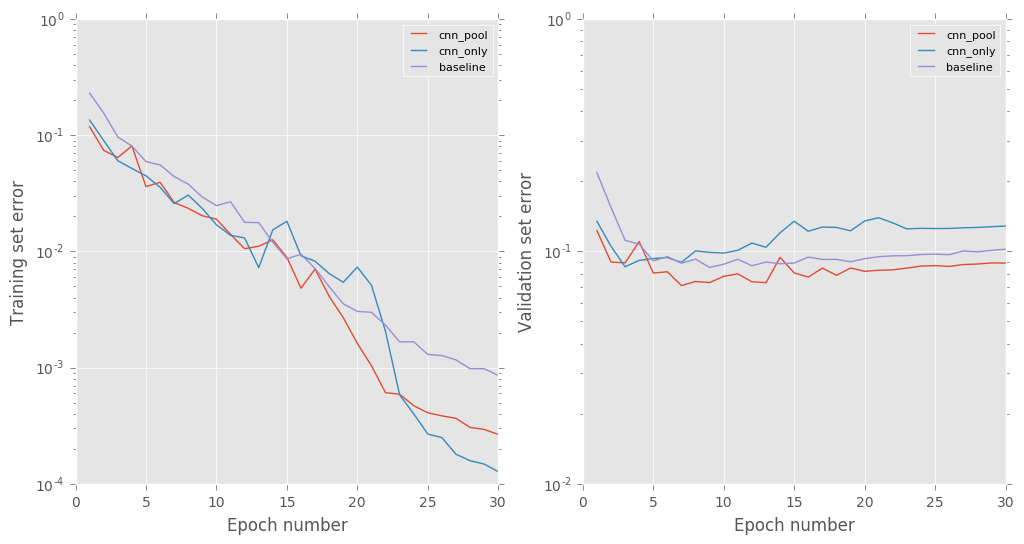

In [38]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
for cnn_type, run in run_info.items():
    stats, keys, run_time = run
    ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(train)']], label=str(cnn_type))
    ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(valid)']], label=str(cnn_type))

ax1.legend(loc='best',prop={'size':8})
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
ax2.legend(loc='best',prop={'size':8})
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')
fig.savefig('cnn_error.pdf')

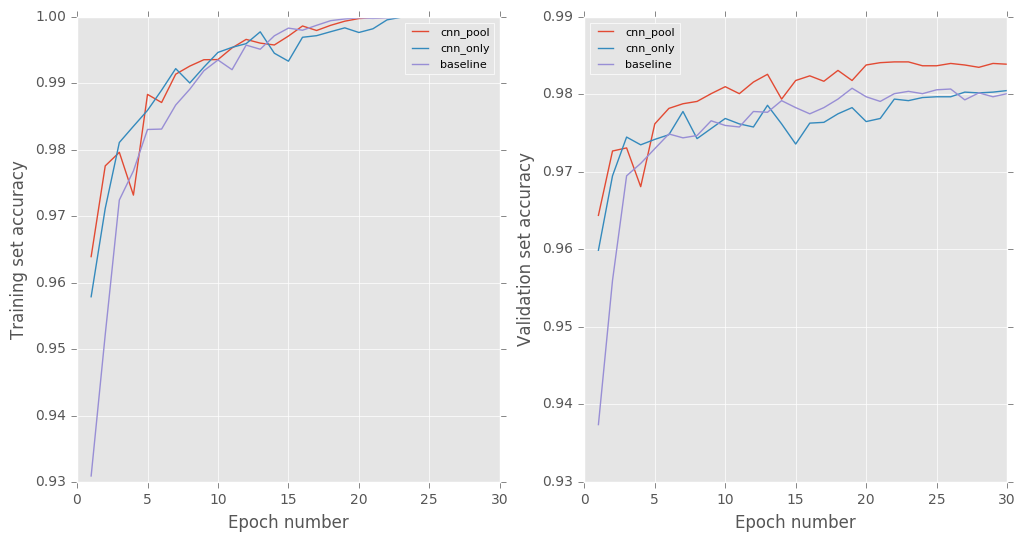

In [36]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
for cnn_type, run in run_info.items():
    stats, keys, run_time = run
    ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['acc(train)']], label=str(cnn_type))
    ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['acc(valid)']], label=str(cnn_type))

ax1.legend(loc='best',prop={'size':8})
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set accuracy')
# ax1.set_yscale('log')
ax2.legend(loc='best',prop={'size':8})
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set accuracy')
# ax2.set_yscale('log')
fig.savefig('cnn_acc.pdf')